# Medical Text

Medical Text Dataset [https://www.kaggle.com/datasets/chaitanyakck/medical-text/data]

In [94]:
import pandas as pd
import nltk

In [95]:
df = pd.read_csv('data/train.dat', sep="\t", header=None)

In [96]:
df.rename(columns={0:'condition', 1:'abstract'}, inplace=True)
df.head()

,condition,abstract
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [97]:
lexical_df = df.copy() # a df to compute lexical analysis on

## Lexical Analysis
Lexical analysis consists of the operations of:
- Sentence Splitting
- Tokenization
- Stemming
- Lemmatization
- POS Tagging

It focuses on the main components of a text (words), and aims to recognize them in relation to the context in which they are used, such as sentences or clauses.

### Sentence Splitting
The technique aims to identify the beginning and end of a textual fragment (sentence or clause) with informative content, even if simple.

To achieve this, it uses orthographic features of words (e.g., uppercase initial letters) and delimiters (e.g., punctuation).

In [98]:
# Split the text into sentences
sentences = lexical_df['abstract'].apply(nltk.sent_tokenize)

In [99]:
sentences[0][2] # Print the third sentence of the first record

'Cardiogenic shock was present in eight patients with infarction of the left anterior descending coronary artery, four with infarction of the right coronary artery, and four with infarction of the circumflex coronary artery.'

In [100]:
lexical_df["sentences"] = sentences # set sentences as df col to save progress

### Word Tokenization
The goal of tokenization is to pinpoint the starting and ending positions of each token, whether it’s a word, a number, or a combination of symbols.

As with sentence splitting, the process relies on orthographic features (e.g., initial capital letters) and delimiters (e.g., punctuation).

In [101]:
tokens = []
for record in sentences:
    words = [nltk.word_tokenize(sentence) for sentence in record]
    tokens.append(words)
lexical_df["tokens"] = tokens # set tokenized sentences as df col to save progress

In [102]:
lexical_df.head()

,condition,abstract,sentences,tokens
0,4,Catheterization laboratory events and hospital...,[Catheterization laboratory events and hospita...,"[[Catheterization, laboratory, events, and, ho..."
1,5,Renal abscess in children. Three cases of rena...,"[Renal abscess in children., Three cases of re...","[[Renal, abscess, in, children, .], [Three, ca..."
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...,[Hyperplastic polyps seen at sigmoidoscopy are...,"[[Hyperplastic, polyps, seen, at, sigmoidoscop..."
3,5,Subclavian artery to innominate vein fistula a...,[Subclavian artery to innominate vein fistula ...,"[[Subclavian, artery, to, innominate, vein, fi..."
4,4,Effect of local inhibition of gamma-aminobutyr...,[Effect of local inhibition of gamma-aminobuty...,"[[Effect, of, local, inhibition, of, gamma-ami..."


### Lemmatization
Post-tokenization techniques address the morphological analysis of word-tokens.

Lemmatization identifies the base form (lemma) of inflected words, preserving their meaning and grammatical category. For example, the token _liked_ maps to the lemma *like*.

This process minimizes lexical variation by consolidating different forms of the same word into a unified representation.

In [103]:
wnl = nltk.WordNetLemmatizer()
lemmatization = []
for record in lexical_df['tokens']:
    lemmatized_record = []
    for words in record:
        lemmatized_record.append([wnl.lemmatize(word) for word in words]) # update sentences into lemmatized
    lemmatization.append(lemmatized_record)
lexical_df["lemmatization"] = lemmatization

In [104]:
lexical_df.head()

,condition,abstract,sentences,tokens,lemmatization
0,4,Catheterization laboratory events and hospital...,[Catheterization laboratory events and hospita...,"[[Catheterization, laboratory, events, and, ho...","[[Catheterization, laboratory, event, and, hos..."
1,5,Renal abscess in children. Three cases of rena...,"[Renal abscess in children., Three cases of re...","[[Renal, abscess, in, children, .], [Three, ca...","[[Renal, abscess, in, child, .], [Three, case,..."
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...,[Hyperplastic polyps seen at sigmoidoscopy are...,"[[Hyperplastic, polyps, seen, at, sigmoidoscop...","[[Hyperplastic, polyp, seen, at, sigmoidoscopy..."
3,5,Subclavian artery to innominate vein fistula a...,[Subclavian artery to innominate vein fistula ...,"[[Subclavian, artery, to, innominate, vein, fi...","[[Subclavian, artery, to, innominate, vein, fi..."
4,4,Effect of local inhibition of gamma-aminobutyr...,[Effect of local inhibition of gamma-aminobuty...,"[[Effect, of, local, inhibition, of, gamma-ami...","[[Effect, of, local, inhibition, of, gamma-ami..."


### Stemming
Stemming, like lemmatization, processes inflected forms but reduces them to their root, which may not correspond to a dictionary word.
Unlike lemmatization, it focuses on inflections that create new words and may change the grammatical class, such as *probable* (adjective) stemming to *probably* (adverb).

In [105]:
porterStemmer = nltk.PorterStemmer()
stemming = []
for record in lexical_df['tokens']:
    stemmed_record = [] # stemmed sentences for each record
    for words in record:
        stemmed_record.append([porterStemmer.stem(word) for word in words]) # update sentences into stemmed
    stemming.append(stemmed_record)

lexical_df["stemming"] = stemming

In [106]:
lexical_df.head()

,condition,abstract,sentences,tokens,lemmatization,stemming
0,4,Catheterization laboratory events and hospital...,[Catheterization laboratory events and hospita...,"[[Catheterization, laboratory, events, and, ho...","[[Catheterization, laboratory, event, and, hos...","[[catheter, laboratori, event, and, hospit, ou..."
1,5,Renal abscess in children. Three cases of rena...,"[Renal abscess in children., Three cases of re...","[[Renal, abscess, in, children, .], [Three, ca...","[[Renal, abscess, in, child, .], [Three, case,...","[[renal, abscess, in, children, .], [three, ca..."
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...,[Hyperplastic polyps seen at sigmoidoscopy are...,"[[Hyperplastic, polyps, seen, at, sigmoidoscop...","[[Hyperplastic, polyp, seen, at, sigmoidoscopy...","[[hyperplast, polyp, seen, at, sigmoidoscopi, ..."
3,5,Subclavian artery to innominate vein fistula a...,[Subclavian artery to innominate vein fistula ...,"[[Subclavian, artery, to, innominate, vein, fi...","[[Subclavian, artery, to, innominate, vein, fi...","[[subclavian, arteri, to, innomin, vein, fistu..."
4,4,Effect of local inhibition of gamma-aminobutyr...,[Effect of local inhibition of gamma-aminobuty...,"[[Effect, of, local, inhibition, of, gamma-ami...","[[Effect, of, local, inhibition, of, gamma-ami...","[[effect, of, local, inhibit, of, gamma-aminob..."


### POS tagging
Part-of-speech (POS) tagging assigns a grammatical category to each token, such as noun, verb, or adjective.

In [107]:
pos = []
for sentence in lexical_df['tokens']:
    pos.append([nltk.pos_tag(token) for token in sentence])
lexical_df["pos_tagging"] = pos

In [108]:
lexical_df.head()

,condition,abstract,sentences,tokens,lemmatization,stemming,pos_tagging
0,4,Catheterization laboratory events and hospital...,[Catheterization laboratory events and hospita...,"[[Catheterization, laboratory, events, and, ho...","[[Catheterization, laboratory, event, and, hos...","[[catheter, laboratori, event, and, hospit, ou...","[[(Catheterization, NNP), (laboratory, NN), (e..."
1,5,Renal abscess in children. Three cases of rena...,"[Renal abscess in children., Three cases of re...","[[Renal, abscess, in, children, .], [Three, ca...","[[Renal, abscess, in, child, .], [Three, case,...","[[renal, abscess, in, children, .], [three, ca...","[[(Renal, JJ), (abscess, NN), (in, IN), (child..."
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...,[Hyperplastic polyps seen at sigmoidoscopy are...,"[[Hyperplastic, polyps, seen, at, sigmoidoscop...","[[Hyperplastic, polyp, seen, at, sigmoidoscopy...","[[hyperplast, polyp, seen, at, sigmoidoscopi, ...","[[(Hyperplastic, JJ), (polyps, NNS), (seen, VB..."
3,5,Subclavian artery to innominate vein fistula a...,[Subclavian artery to innominate vein fistula ...,"[[Subclavian, artery, to, innominate, vein, fi...","[[Subclavian, artery, to, innominate, vein, fi...","[[subclavian, arteri, to, innomin, vein, fistu...","[[(Subclavian, JJ), (artery, NN), (to, TO), (i..."
4,4,Effect of local inhibition of gamma-aminobutyr...,[Effect of local inhibition of gamma-aminobuty...,"[[Effect, of, local, inhibition, of, gamma-ami...","[[Effect, of, local, inhibition, of, gamma-ami...","[[effect, of, local, inhibit, of, gamma-aminob...","[[(Effect, NNP), (of, IN), (local, JJ), (inhib..."


### Stop-words Removal
Stop-words are common words that do not carry specific meaning, such as articles, prepositions, and conjunctions.
It is usually performed after lexical analysis to avoid inaccuracies in subsequent syntactic or semantic analyses.

In [127]:
stopwords = nltk.corpus.stopwords.words('english')

stopwords_removal = []

for record in lexical_df['tokens']:
    filtered_record = []
    for sentence in record:
        filtered_sentence = [word for word in sentence if word.lower() not in stopwords]
        filtered_record.append(filtered_sentence)

    stopwords_removal.append(filtered_record)

lexical_df["stopwords_removal"] = stopwords_removal

In [128]:
lexical_df.head()

,condition,abstract,sentences,tokens,lemmatization,stemming,pos_tagging,stopwords_removal
0,4,Catheterization laboratory events and hospital...,[Catheterization laboratory events and hospita...,"[[Catheterization, laboratory, events, and, ho...","[[Catheterization, laboratory, event, and, hos...","[[catheter, laboratori, event, and, hospit, ou...","[[(Catheterization, NNP), (laboratory, NN), (e...","[[Catheterization, laboratory, events, hospita..."
1,5,Renal abscess in children. Three cases of rena...,"[Renal abscess in children., Three cases of re...","[[Renal, abscess, in, children, .], [Three, ca...","[[Renal, abscess, in, child, .], [Three, case,...","[[renal, abscess, in, children, .], [three, ca...","[[(Renal, JJ), (abscess, NN), (in, IN), (child...","[[Renal, abscess, children, .], [Three, cases,..."
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...,[Hyperplastic polyps seen at sigmoidoscopy are...,"[[Hyperplastic, polyps, seen, at, sigmoidoscop...","[[Hyperplastic, polyp, seen, at, sigmoidoscopy...","[[hyperplast, polyp, seen, at, sigmoidoscopi, ...","[[(Hyperplastic, JJ), (polyps, NNS), (seen, VB...","[[Hyperplastic, polyps, seen, sigmoidoscopy, m..."
3,5,Subclavian artery to innominate vein fistula a...,[Subclavian artery to innominate vein fistula ...,"[[Subclavian, artery, to, innominate, vein, fi...","[[Subclavian, artery, to, innominate, vein, fi...","[[subclavian, arteri, to, innomin, vein, fistu...","[[(Subclavian, JJ), (artery, NN), (to, TO), (i...","[[Subclavian, artery, innominate, vein, fistul..."
4,4,Effect of local inhibition of gamma-aminobutyr...,[Effect of local inhibition of gamma-aminobuty...,"[[Effect, of, local, inhibition, of, gamma-ami...","[[Effect, of, local, inhibition, of, gamma-ami...","[[effect, of, local, inhibit, of, gamma-aminob...","[[(Effect, NNP), (of, IN), (local, JJ), (inhib...","[[Effect, local, inhibition, gamma-aminobutyri..."


# Syntax Analysis
Syntax analysis consists of:
- Shallow Parsing
- Deep Parsing

### Shallow Parsing
Syntactic parsing extends chunking by generating a parse tree. This tree organizes POS-tagging results as leaf nodes and syntactic structures (often chunks) as intermediate nodes, connected hierarchically without representing specific relationships.


In [109]:
syntax_df = df.copy() # a df to compute syntax analysis on

In [121]:
# Define the grammar and the chunk parser
grammar = "NP: {<NNP><NNP>}"
cp = nltk.RegexpParser(grammar) # chunk parser

# Apply chunking to each record
chunking = []
for record in lexical_df['pos_tagging']:
    chunked_record = [cp.parse(sentence) for sentence in record]

    chunking.append(chunked_record)

# Save the chunking results into the dataframe
syntax_df["chunking"] = chunking

In [122]:
# Display the dataframe
syntax_df.head()

,condition,abstract,chunking
0,4,Catheterization laboratory events and hospital...,"[[(Catheterization, NNP), (laboratory, NN), (e..."
1,5,Renal abscess in children. Three cases of rena...,"[[(Renal, JJ), (abscess, NN), (in, IN), (child..."
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...,"[[(Hyperplastic, JJ), (polyps, NNS), (seen, VB..."
3,5,Subclavian artery to innominate vein fistula a...,"[[(Subclavian, JJ), (artery, NN), (to, TO), (i..."
4,4,Effect of local inhibition of gamma-aminobutyr...,"[[(Effect, NNP), (of, IN), (local, JJ), (inhib..."


(S
  There/EX
  was/VBD
  one/CD
  in-laboratory/JJ
  death/NN
  (/(
  shock/JJ
  patient/NN
  with/IN
  infarction/NN
  of/IN
  the/DT
  left/JJ
  anterior/JJ
  descending/VBG
  coronary/JJ
  artery/NN
  )/)
  ./.)


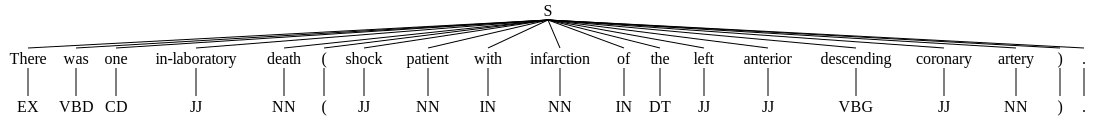

In [123]:
# Display the chunking result for the first record
print(syntax_df['chunking'][0][4])
syntax_df['chunking'][0][4]